# Modeling Onion vs All News
## Project 3: Subreddit Classification using NLP
### Robbie Davison

## 1) Imports

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

pd.set_option('display.max_columns', None)
%config InlineBackend.figure_format = 'retina'

<hr style='border-top: 10px solid #000;'> 

## 2) Read in Subreddit Data

In [3]:
master = pd.read_csv('./data/master_1_df.csv')

In [4]:
master.head()

,title,tag,score,y
0,I’m a Heterosexual Woman Who’s Politically Opp...,onion,1,1
1,Cruise Ship Erupts from Mt. St. Helen's After ...,onion,1,1
2,Is Our Wealth Hurting Africa's Feelings?,onion,1,1
3,Islam Is Incompatible With Country-Western Cul...,onion,1,1
4,Xi Jinping Vows To Combat Coronavirus By Makin...,onion,1,1


### Make Masks

In [5]:
onion = master['tag'] == 'onion'
not_onion = master['tag'] == 'not onion'
us_news = master['tag'] == 'us news'
world_news = master['tag'] == 'world news'
news = master['tag'] == 'news'
breitbart = master['tag'] == 'breitbart'

### Obtain 300 Reddits from each Non-Onion source and combine with Onion titles

In [6]:
data = pd.concat([
    master.loc[onion, :],
    master.loc[not_onion, :].sample(n=300, random_state=8),
    master.loc[us_news, :].sample(n=300, random_state=8),
    master.loc[world_news, :].sample(n=300, random_state=8),
    master.loc[news, :].sample(n=300, random_state=8),
    master.loc[breitbart, :].sample(n=300, random_state=8)
])

### Calculate the Baseline

In [7]:
#y.value_counts(normalize=True)

### Baseline = 0.6

<hr style='border-top: 10px solid #000;'> 

## 3) Logistic Regression

In [8]:
X = data['title']
y = data['y']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    stratify = y,
                                                    random_state=24)#, test_size=0.33

In [10]:
pipe_log = Pipeline([
    ('tf', TfidfVectorizer()),
    ('log', LogisticRegression(solver='liblinear',
                               random_state=8))
])

In [11]:
params_log = {'tf__stop_words': ['english', None],
          'tf__ngram_range': [(1,1), (1,2), (1,3)],
          'tf__max_features': [None, 100, 500, 1500],
          'tf__use_idf': [True, False], 
          'log__penalty': ['l1', 'l2']}

In [12]:
log_grid_1 = GridSearchCV(pipe_log, params_log, cv=5)

In [13]:
log_grid_1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [14]:
log_grid_1.best_params_

{'log__penalty': 'l2',
 'tf__max_features': None,
 'tf__ngram_range': (1, 1),
 'tf__stop_words': None,
 'tf__use_idf': False}

In [15]:
# Evaluate model.
print(f'Score on training set: {log_grid_1.score(X_train, y_train).round(4)}')
print(f'Score on testing set: {log_grid_1.score(X_test, y_test).round(4)}')

Score on training set: 0.8949
Score on testing set: 0.7552


# 0.755
baseline: 0.6

not onion: 0.812/0.5

<hr style='border-top: 10px solid #000;'> 

## 4) Decision Tree

In [16]:
tf = TfidfVectorizer(stop_words='english')
X_trainee = tf.fit_transform(X_train)
X_trainee_df = pd.DataFrame(X_trainee.toarray(),
                            columns=tf.get_feature_names())
X_trainee_df.head()

000   05   06   10  100  106  109   11  110k  116  117   12  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   

   123articleonline  126  1291   13  135  13th   14  140  144   15  150  156  \
0               0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1               0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2               0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3               0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4               0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   15th   16  1619   17  17th   18  1840182471  1877  18s   19  1910s  1918  \
0   0.0  0.0   0.0  0.0   0.0  0.0         0.0   0.0  0.0  0.0    0.0   0.0   
1   0.0  0.0   0.0  0.0   0.0  0.0         0.0   0.0  0.0  0.0    0.0   0.0   
2   0.0  0.0   0.0  0.0   0.0  0.0         0.0   0.0  0.0  0.0    0.0   0.0   
3   0.0  0.0   0.0  0.0   0.0  0.0         0.0   0.0  0.0  0.0    0.0   0.0   
4   0.0  0.0   0.0  0.0   0.0  0.0         0.0   0.0  0.0  0.0    0.0   0.0   

   1963  1985  1988  199  1991  1998  1st   20  200  2000  2001  2003  2005  \
0   0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   

   2010  2011  2012  2013  2016  2017  2019  2020  2022  2024  2029  2030  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   2040   21   22   23  23andme   24  24hours   25   26   27  27th   28  280  \
0   0.0  0.0  0.0  0.0      0.0  0.0      0.0  0.0  0.0  0.0   0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0      0.0  0.0      0.0  0.0  0.0  0.0   0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0      0.0  0.0      0.0  0.0  0.0  0.0   0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0      0.0  0.0      0.0  0.0  0.0  0.0   0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0      0.0  0.0      0.0  0.0  0.0  0.0   0.0  0.0  0.0   

   28th   29   2a   2b  2kuz4qh  2nd  2ryou5u  2t7i97m   30  300  300m  30pm  \
0   0.0  0.0  0.0  0.0      0.0  0.0      0.0      0.0  0.0  0.0   0.0   0.0   
1   0.0  0.0  0.0  0.0      0.0  0.0      0.0      0.0  0.0  0.0   0.0   0.0   
2   0.0  0.0  0.0  0.0      0.0  0.0      0.0      0.0  0.0  0.0   0.0   0.0   
3   0.0  0.0  0.0  0.0      0.0  0.0      0.0      0.0  0.0  0.0   0.0   0.0   
4   0.0  0.0  0.0  0.0      0.0  0.0      0.0      0.0  0.0  0.0   0.0   0.0   

   30x   34  342   35   37   3d   3m  3rd   40  400  420  4200  42enne   43  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0   

   437  4448  44th   45  4523   48  49ers   4k  4th   50  500  500m   51   52  \
0  0.0   0.0   0.0  0.0   0.0  0.0    0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
1  0.0   0.0   0.0  0.0   0.0  0.0    0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
2  0.0   0.0   0.0  0.0   0.0  0

In [22]:
X_trainee_df.shape

(1875, 6734)

In [23]:
6734/2

3367.0

In [25]:
pipe_dt = Pipeline([
    ('tf', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier(random_state=8))
])

params_dt = {'tf__stop_words': ['english', None],
          'tf__ngram_range': [(1,1), (1,2)], #, (1,3)],
          'tf__max_features': [None, 1500],
          'tf__use_idf': [True, False],
          'dt__max_depth': [None, 3400],
          #'dt__min_samples_split': [2, 3],
          #'dt__min_samples_leaf': [1, 2, 3]
            }

In [26]:
dt_grid_1 = GridSearchCV(pipe_dt, params_dt, cv=5)

In [27]:
dt_grid_1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [28]:
dt_grid_1.best_params_

{'dt__max_depth': None,
 'tf__max_features': 1500,
 'tf__ngram_range': (1, 1),
 'tf__stop_words': 'english',
 'tf__use_idf': True}

In [29]:
# Evaluate model.
print(f'Score on training set: {dt_grid_1.score(X_train, y_train).round(4)}')
print(f'Score on testing set: {dt_grid_1.score(X_test, y_test).round(4)}')

Score on training set: 0.9925
Score on testing set: 0.6752


# 0.675
baseline 0.6

not onion: 0.736/0.5

<hr style='border-top: 10px solid #000;'> 

## 5) Multinomial Naive Bayes

In [32]:
pipe_mnb = Pipeline([
    ('tf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

params_mnb = {'tf__stop_words': ['english', None],
          'tf__ngram_range': [(1,1), (1,2)], #, (1,3)],
          'tf__max_features': [None, 1500],
          'tf__use_idf': [True, False],
          'mnb__alpha': [.5, 1, 2]}

grid_mnb = GridSearchCV(pipe_mnb, params_mnb, cv=5)

grid_mnb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [33]:
grid_mnb.best_params_

{'mnb__alpha': 0.5,
 'tf__max_features': None,
 'tf__ngram_range': (1, 1),
 'tf__stop_words': None,
 'tf__use_idf': True}

In [34]:
print(f'Score on training set: {grid_mnb.score(X_train, y_train).round(4)}')
print(f'Score on testing set: {grid_mnb.score(X_test, y_test).round(4)}')

Score on training set: 0.9771
Score on testing set: 0.7808


# 0.781
baseline 0.6

not onion: 0.814/0.5

<hr style='border-top: 10px solid #000;'> 

## 6) Gaussian Bayes

In [33]:
tf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

# transform X to dense matrix
X_train_tf = tf.fit_transform(X_train).toarray()
X_test_tf = tf.transform(X_test).toarray()

gaus = GaussianNB()

gaus.fit(X_train_tf, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [34]:
print(f'Score on training set: {gaus.score(X_train_tf, y_train).round(4)}')
print(f'Score on testing set: {gaus.score(X_test_tf, y_test).round(4)}')

Score on training set: 0.9984
Score on testing set: 0.7056


# 0.706
baseline 0.6

not onion: 0.776/0.5

<hr style='border-top: 10px solid #000;'> 

## 7) Random Forrest/ Bagging

In [17]:
import warnings
warnings.simplefilter(action="ignore")

In [18]:
pipe_rf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=8))
])

params_rf = {'tf__stop_words': ['english', None],
             #'tf__ngram_range': [(1,1), (1,2)], #, (1,3)],
             #'tf__max_features': [None, 200, 500],
             'tf__use_idf': [True, False], 
             #'rf__max_depth': [None, 200],
             #'rf__n_estimators': [100],
             'rf__max_features': ['auto', None],
             #'rf__min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(pipe_rf, params_rf, cv=5)

grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [36]:
grid_rf.best_params_

{'rf__max_features': 'auto', 'tf__stop_words': None, 'tf__use_idf': False}

In [37]:
print(f'Score on training set: {grid_rf.score(X_train, y_train).round(4)}')
print(f'Score on testing set: {grid_rf.score(X_test, y_test).round(4)}')

Score on training set: 0.9803
Score on testing set: 0.6656


# 0.666
baseline 0.6

not onion: 0.764/0.5

#### Random Forrest proved better than Bagging because the max features were auto and not none. Also, CountVectorizer was favored over TFiDF

<hr style='border-top: 10px solid #000;'> 

## 8) Look into what types of posts were labeled incorrectly by the Multinomial Naive Bayes Model

In [40]:
pd.set_option('display.max_colwidth', -1)

In [35]:
results_mnb = pd.DataFrame(grid_mnb.predict(X_test), columns=['predicted'])
results_mnb['actual'] = np.where(y_test==1, 1, 0)
results_mnb['post'] = list(X_test)
results_mnb['grade'] = np.where(results_mnb['predicted'] != results_mnb['actual'], 'wrong', 'right')
results_mnb['pred_probs'] = [i[1] for i in grid_mnb.predict_proba(X_test)]


In [47]:
results_mnb.loc[results_mnb['pred_probs'] > .5, :].sort_values(by='pred_probs', ascending=False).head(40)

,predicted,actual,post,grade,pred_probs
48,1,1,"‘No Way To Prevent This,’ Says Only Nation Where This Regularly Happens",right,0.946698
148,1,1,Body Positivity Win: This Thing Seems Overweight For Whatever The Hell It Is But It’s Still Beautiful,right,0.923297
463,1,1,Grow Up Guys: These Immature 6th-Grade Boys Start Laughing Every Time Their Sex Ed Teacher Talks About A Man’s Pempler Going In A Woman’s Vooguss,right,0.912636
435,1,1,Bush Regales Dinner Guests With Impromptu Oratory On Virgil's Minor Works [oldie but goodie. simpler times...],right,0.903303
601,1,1,The Onion Reviews 'Ghostbusters',right,0.902139
347,1,1,"Nation’s Indigenous People Confirm They Don’t Need Special Holiday, Just Large Swaths Of Land Returned Immediately",right,0.894884
589,1,1,Someone Built A World In ‘Minecraft’ Where 9/11 Never Happened And It’s Incredible,right,0.888401
142,1,1,Excited Park Rangers Announce Lincoln Memorial Actually A Girl After Statue Gives Birth To Litter Of Tiny Marble Abraham Lincolns,right,0.865935
187,1,1,Newly Discovered Scrolls Suggest Jesus Devoured Twin Messiah In Womb,right,0.862460
473,1,1,Apple introduces Revolutionary computer without keyboard,right,0.861588


In [43]:
results_mnb.groupby(by='grade').head(25)

,predicted,actual,post,grade,pred_probs
0,0,1,42 Million Dead In Bloodiest Black Friday Weekend On Record,wrong,0.181970
1,0,0,Delingpole: Donald Trump Vs Greta and the Prophets of Doom,right,0.184012
2,0,0,Explained: Why China has emerged as the epicentre of global outbreaks of disease,right,0.106313
3,1,1,Their Dorkiest Actor Friend’s Time To Shine: This Couple Needs Someone to Officiate Their Secular Wedding,right,0.658683
4,0,0,"The coronavirus could’ve been leaked from an institute, the number of infected could also be much higher.",right,0.267820
5,1,1,Fascinating: Anthropologists Now Believe That Modern National Doughnut Day Celebrations Were Adapted From Early Pagan Doughnut Days,right,0.614860
6,0,0,"Those Against Amotekun Are Agents Of Criminals – Aare Ona Kankanfo, Gani Adams",right,0.275015
7,0,0,"Nutmobile Destroyed, Mr. Peanut Dead In Tragic Accident",right,0.284960
8,0,0,Schiff: Intelligence Community Is Withholding Ukraine Documents from Congress,right,0.306646
9,0,0,38 year old mother attempts to avoid police by dressing up as her own daughter,right,0.386495


## 9) Make ROC AUC and Bar Charts

### First make probability distribution for the Multinomial NB Model

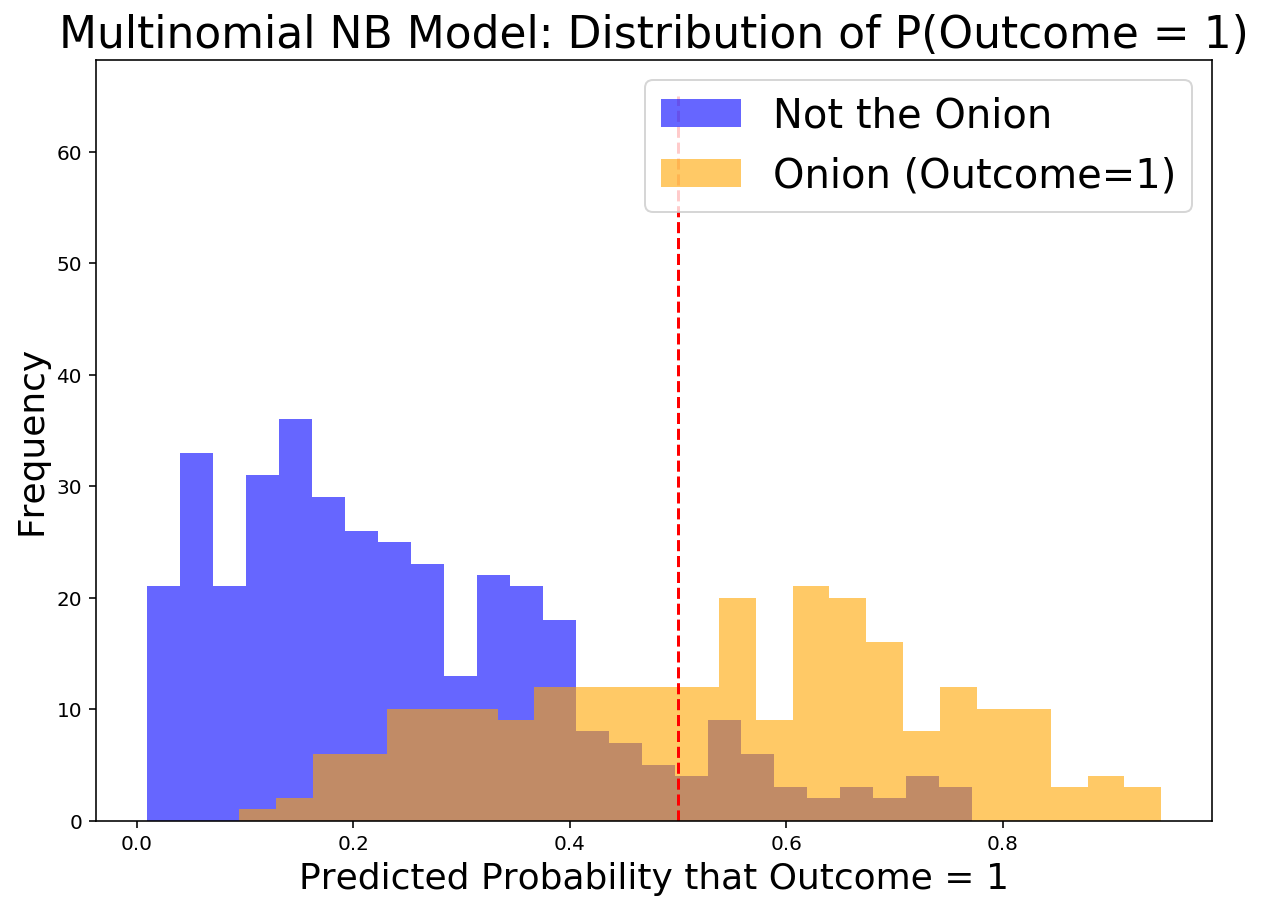

In [37]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(results_mnb[results_mnb['actual'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Not the Onion')
plt.hist(results_mnb[results_mnb['actual'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Onion (Outcome=1)')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 65,
           color = 'r',
           linestyle = '--')

# Label axes.
plt.title('Multinomial NB Model: Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);

### Now plot the ROC AUC curve

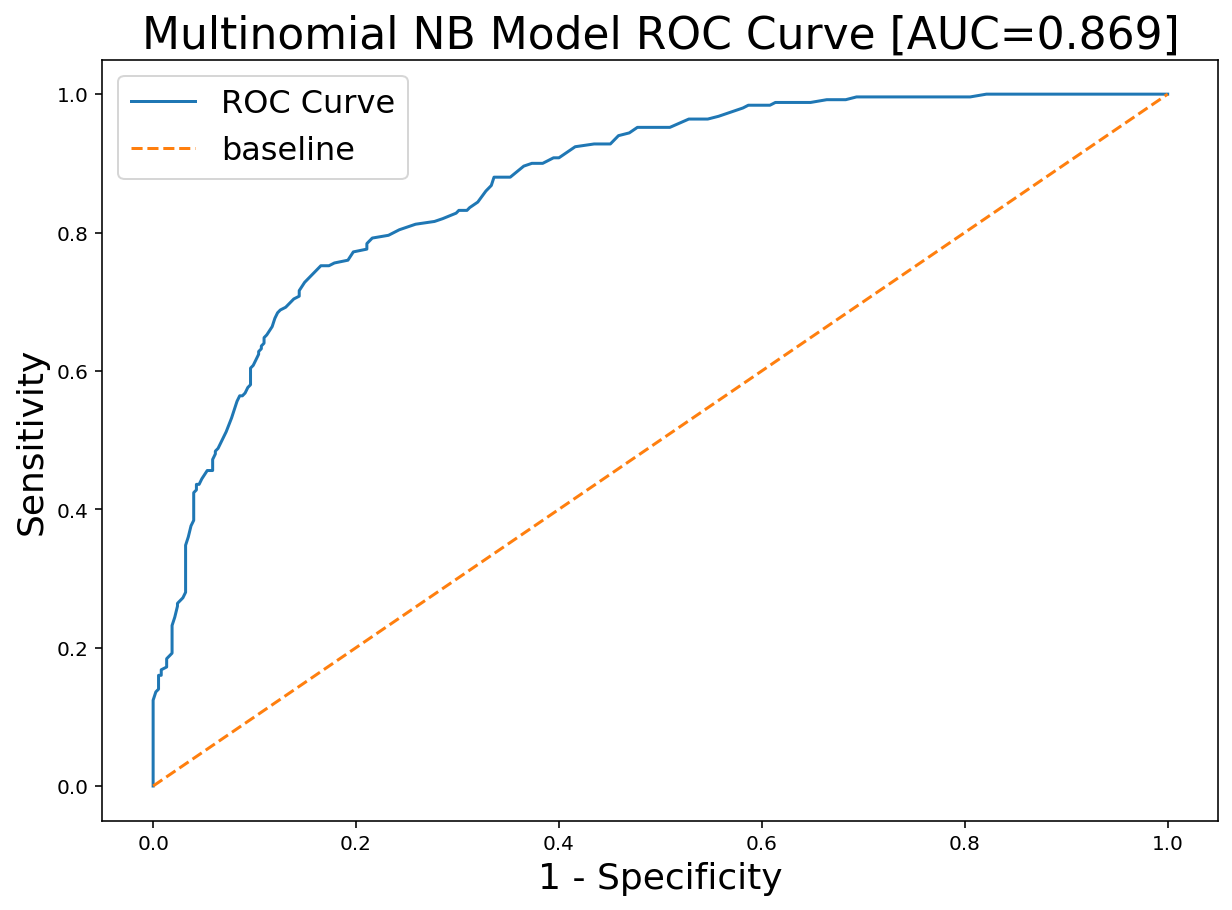

In [38]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(results_mnb, 'actual', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(results_mnb, 'actual', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f"Multinomial NB Model ROC Curve [AUC={round(roc_auc_score(results_mnb['actual'], results_mnb['pred_probs']), 3)}]", fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [39]:
1 - FPR(results_mnb, 'actual', 'pred_probs', .5)

0.904

## Make Distribution of Logistic Regression Probabilities

In [22]:
results_log = pd.DataFrame(log_grid_1.predict(X_test), columns=['predicted'])
results_log['actual'] = np.where(y_test==1, 1, 0)
results_log['post'] = list(X_test)
results_log['grade'] = np.where(results_log['predicted'] != results_log['actual'], 'wrong', 'right')
results_log['pred_probs'] = [i[1] for i in log_grid_1.predict_proba(X_test)]


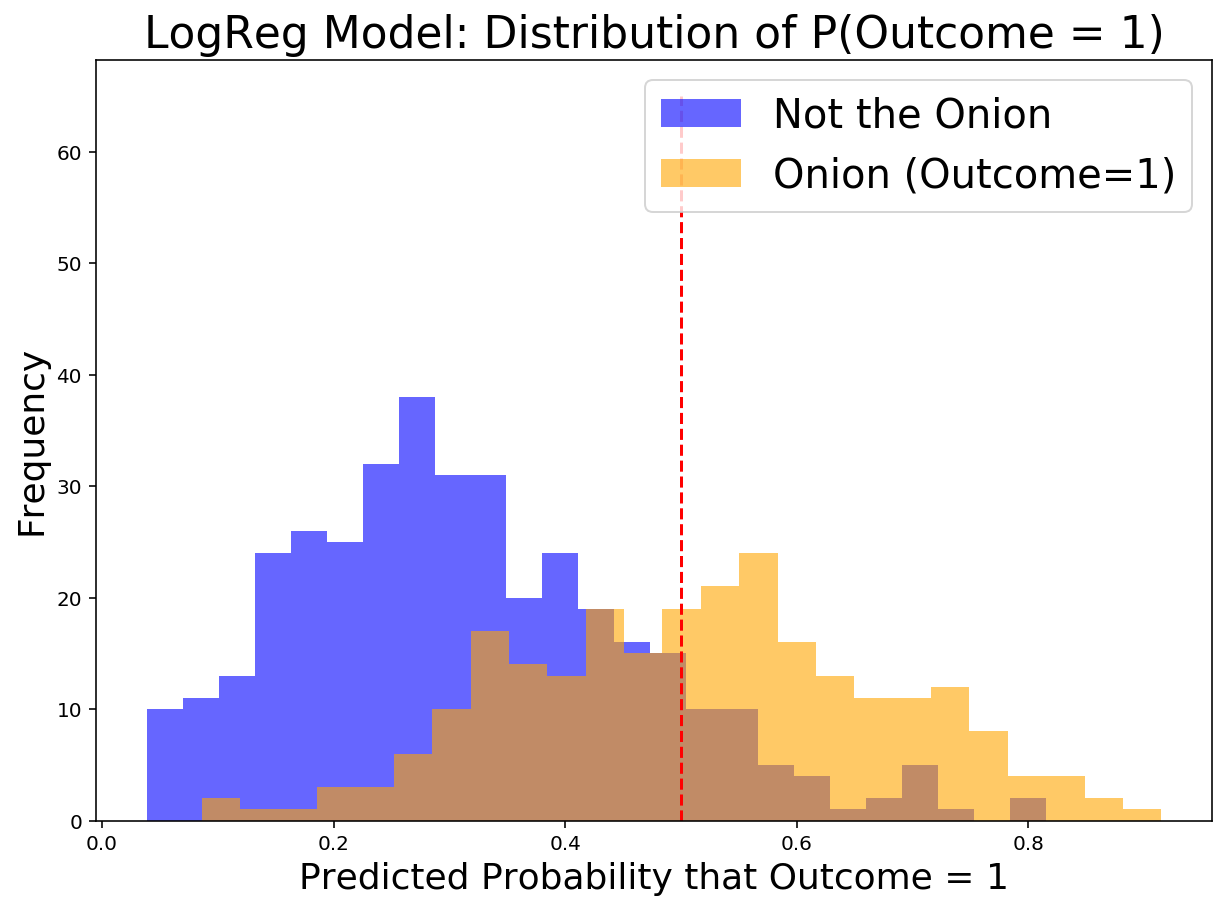

In [23]:
plt.figure(figsize = (10,7))
plt.hist(results_log[results_log['actual'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Not the Onion')
plt.hist(results_log[results_log['actual'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Onion (Outcome=1)')
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 65,
           color = 'r',
           linestyle = '--')
plt.title('LogReg Model: Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)
plt.legend(fontsize = 20);

### plot the curve

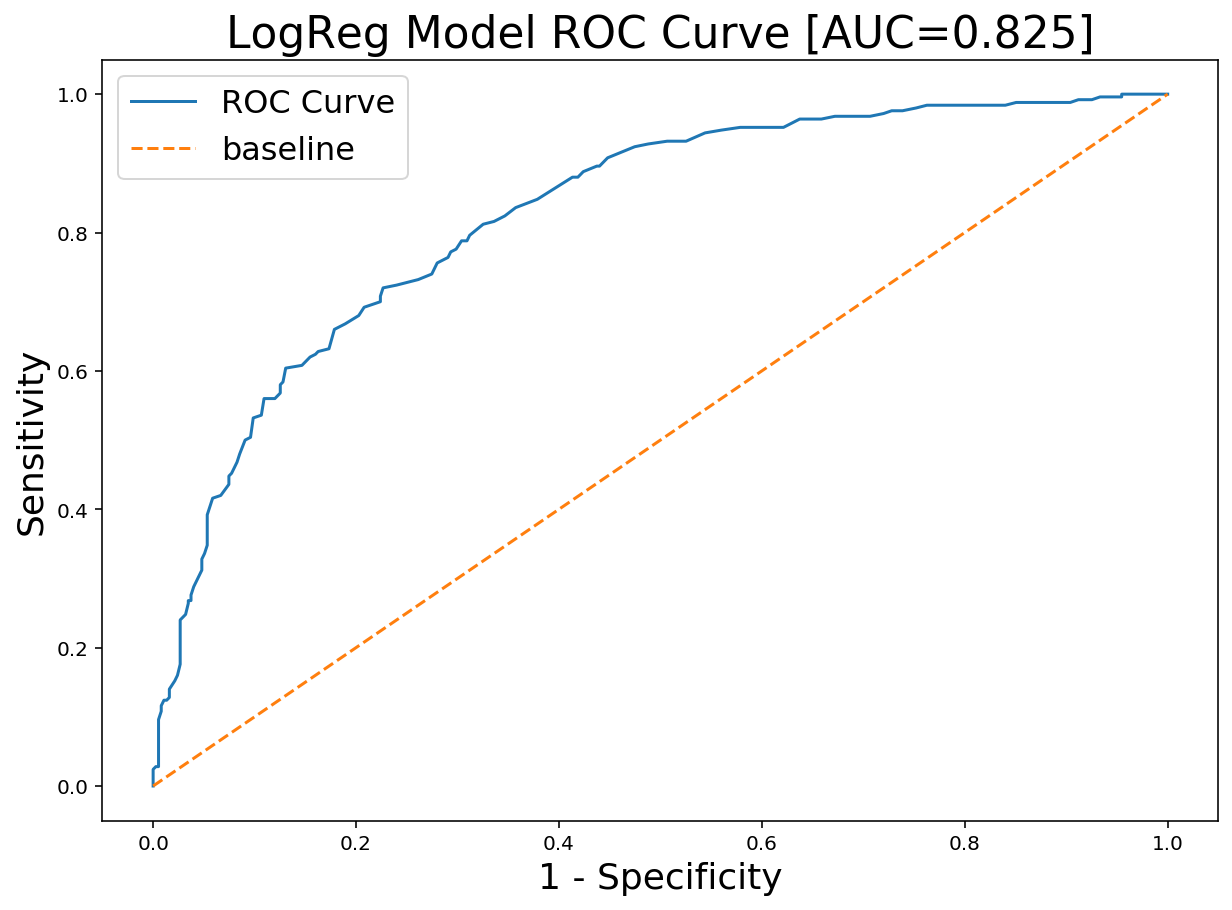

In [26]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(results_log, 'actual', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(results_log, 'actual', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f"LogReg Model ROC Curve [AUC={round(roc_auc_score(results_log['actual'], results_log['pred_probs']), 3)}]", fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [30]:
1 - FPR(results_log, 'actual', 'pred_probs', .5)

0.8853333333333333

## Investigate Lower/Higher Frequency words for logistic regression in the Corpus

In [27]:
model2 = log_grid_1.best_estimator_
coef2 = model2.named_steps['log'].coef_[0]
cols2 = model2.named_steps['tf'].get_feature_names()
words_df2 = pd.DataFrame(zip(cols2,coef2), columns=['words', 'coefficient'])

In [28]:
words_df2.sort_values(by='coefficient').head(11).round(2)

,words,coefficient
1456,coronavirus,-2.94
6341,trump,-2.81
1177,china,-2.36
6468,us,-1.93
3442,kobe,-1.71
939,bryant,-1.50
3101,impeachment,-1.41
6314,trial,-1.27
6812,wuhan,-1.23
4614,police,-1.21


In [29]:
words_df2.sort_values(by='coefficient', ascending=False).head(11).round(2)

,words,coefficient
6169,this,3.05
4272,onion,2.56
2873,he,2.28
4087,nation,2.02
6160,they,1.86
4230,of,1.62
3359,just,1.50
6834,you,1.22
2866,have,1.20
162,about,1.12
